In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.interpolate import interp2d
from scipy.stats import multivariate_normal
from matplotlib.animation import FuncAnimation

%matplotlib widget

sys.path.append(os.path.join(os.path.dirname(os.path.dirname("")), "../src"))
from utils import generate_map  # NOQA
from rh_ma_vulcan import MultiAgentVulcan  # NOQA
from rh_sa_vulcan import SingleAgentVulcan  # NOQA
from map import Grid, RewardMap, Parameters, Action, ActionType  # NOQA

In [2]:
def setup_problem(problem_type: str):
    gp_locations = [(1, 1), (7, 7), (4, 4), (1, 7), (7, 1)]
    if problem_type == "empty_2":
        agent_locations = [(0, 0), (0, 2)]
        maze = None
    elif problem_type == "empty_3":
        agent_locations = [(0, 0), (0, 2), (2, 0)]
        maze = None
    elif problem_type == "maze_2":
        agent_locations = [(0, 0), (0, 3)]
        maze = np.ones((8, 8))
        maze[0, 2] = 0
        maze[1, 2] = 0
        maze[2, 2] = 0
        maze[2, 3] = 0
        maze[2, 4] = 0
        maze[2, 5] = 0
        maze[5, 5] = 0
        maze[5, 4] = 0
        maze[5, 3] = 0
        maze[5, 2] = 0
        maze[6, 5] = 0
        maze[7, 5] = 0
    else:
        raise ValueError("Invalid problem type")

    params = Parameters(
        theta_1=np.float64(0.4),
        theta_2=np.float64(0.01),
        u_tilde=np.float64(1.4),
        P_1=np.float64(0.98),
        P_2=np.float64(0.002),
        J=np.int64(5),
        measurement_noise=np.float64(0.2),
        distance_simplification=True,
    )


    grid, reward_map = generate_map(
        8, 
        8, 
        grid=maze, 
        agent_locations=agent_locations, 
        gp_means = np.ones(len(gp_locations)).tolist(), 
        gp_locations=gp_locations, 
        parameters=params
    )
    

    x = np.linspace(0, reward_map.num_of_cols, 1000)
    y = np.linspace(0, reward_map.num_of_rows, 1000)
    xx, yy = np.meshgrid(x, y)
    meshgrid = np.dstack((xx, yy))
    zz = np.zeros_like(xx)
    for i in range(len(reward_map.locations)):
        linear_location = reward_map.locations[i]
        location_coord = reward_map.get_coordinate(linear_location)
        location_coord = np.array([location_coord[1], location_coord[0]])
        gaussian = reward_map.means[i] * multivariate_normal.pdf(
            meshgrid, mean=location_coord, cov=1
        )
        zz += gaussian
    zz /= np.max(zz)


    zz_obstacle = None
    if maze is not None:
        y_obstacle = np.linspace(0, reward_map.num_of_rows, maze.shape[0])
        x_obstacle = np.linspace(0, reward_map.num_of_cols, maze.shape[1])

        obstacles_interpolated = interp2d(x_obstacle, y_obstacle, maze, kind="linear")
        zz_obstacle = obstacles_interpolated(x, y)
        zz_obstacle[np.where(zz_obstacle >= 0.2)] = 1.0

    return grid, reward_map, zz, zz_obstacle

In [56]:
def plot_animation(agent_paths, reward_map, zz, zz_obstacle):

    fig, ax = plt.subplots()
    agent_colors = ["r", "b", "g", "y", "m", "c", "k"]

    padding = 0.25 
    ax.imshow(
        zz,
        # extent=(0 - padding, reward_map.num_of_cols + padding, reward_map.num_of_rows + padding, 0 - padding),
        extent=(reward_map.num_of_cols + padding, 0 - padding, 0 - padding, reward_map.num_of_rows + padding),
        cmap="hot",
        alpha=0.7
    )
    if zz_obstacle is not None:
        # ax.imshow(zz_obstacle, extent=(0 - padding, reward_map.num_of_cols + padding, reward_map.num_of_rows + padding, 0 - padding), cmap="gray", alpha=0.5)
        ax.imshow(zz_obstacle, extent=(reward_map.num_of_cols + padding, 0 - padding, 0 - padding, reward_map.num_of_rows + padding), cmap="gray", alpha=0.5)

    agent_colors = ["g", "b", "r", "deeppink", "y", "m", "c", "w"]
    num_of_agents = len(agent_paths)

    lines = []
    starts = []
    ends = []
    for agent in range(num_of_agents):
        (line,) = ax.plot([], [], lw=2, color=agent_colors[agent], ls="--", alpha=0.7)
        (start,) = ax.plot(
            [], [], lw=2, color=agent_colors[agent], marker="x", alpha=0.7
        )
        (end,) = ax.plot(
            [], [], lw=2, color=agent_colors[agent], marker="o", alpha=0.7
        )
        lines.append(line)
        starts.append(start)
        ends.append(end)

    def init():
        for i, path in enumerate(agent_paths):
            starts[i].set_data(path[0][1], path[0][0])
        return starts

    def update(frame):
        for i, path in enumerate(agent_paths):
            x_data = [point[1] for point in path[: frame + 1]]
            y_data = [point[0] for point in path[: frame + 1]]
            lines[i].set_data(x_data, y_data)
            ends[i].set_data(path[frame][1], path[frame][0])
        return lines

    frames = max(len(path) for path in agent_paths)
    ani = FuncAnimation(
        fig, update, frames=frames, init_func=init, blit=True, repeat=False
    )
    return HTML(ani.to_jshtml())

### Visualize paths of turtlebots for different scenarios

#### Empty Space - 2 Robots

In [57]:
agent_a = [np.array([0, 0]), np.array([0, 1]), np.array([1, 1]), np.array([2, 1]), np.array([2, 2]), np.array([1, 2]), np.array([1, 1]), np.array([1, 0]), np.array([2, 0]), np.array([3, 0]), np.array([3, 1]), np.array([3, 2]), np.array([3, 3]), np.array([4, 3]), np.array([4, 4]), np.array([5, 4]), np.array([5, 5]), np.array([4, 5]), np.array([3, 5]), np.array([3, 4]), np.array([2, 4]), np.array([2, 5]), np.array([2, 6]), np.array([2, 7]), np.array([1, 7]), np.array([1, 6])]
agent_b = [np.array([0, 2]), np.array([0, 1]), np.array([1, 1]), np.array([2, 1]), np.array([2, 2]), np.array([1, 2]), np.array([1, 1]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([0, 0]), np.array([0, 1]), np.array([0, 2]), np.array([0, 3]), np.array([1, 3]), np.array([2, 3]), np.array([3, 3]), np.array([4, 3]), np.array([4, 4]), np.array([5, 4]), np.array([5, 5]), np.array([4, 5]), np.array([3, 5]), np.array([3, 4]), np.array([2, 4]), np.array([2, 5])]
rh_sa_vulcan = [agent_a, agent_b]

agent_a = [np.array([0, 0]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([2, 0]), np.array([1, 0]), np.array([2, 0]), np.array([3, 0])]
agent_b = [np.array([0, 2]), np.array([1, 2]), np.array([2, 2]), np.array([1, 2]), np.array([2, 2]), np.array([1, 2]), np.array([2, 2]), np.array([1, 2]), np.array([2, 2]), np.array([1, 2]), np.array([2, 2]), np.array([1, 2]), np.array([2, 2]), np.array([1, 2]), np.array([2, 2]), np.array([1, 2]), np.array([2, 2]), np.array([1, 2]), np.array([2, 2]), np.array([1, 2]), np.array([2, 2]), np.array([1, 2]), np.array([2, 2]), np.array([1, 2]), np.array([2, 2]), np.array([3, 2])]
rh_sa_ca_vulcan = [agent_a, agent_b]

agent_a = [np.array([0, 0]), np.array([1, 0]), np.array([1, 1]), np.array([2, 1]), np.array([2, 2]), np.array([2, 1]), np.array([2, 0]), np.array([3, 0]), np.array([3, 1]), np.array([3, 2]), np.array([3, 1]), np.array([3, 0]), np.array([3, 1]), np.array([3, 0]), np.array([3, 1]), np.array([3, 0]), np.array([3, 1]), np.array([3, 0]), np.array([3, 1]), np.array([3, 0]), np.array([3, 1]), np.array([3, 0]), np.array([3, 1]), np.array([3, 0]), np.array([3, 1]), np.array([4, 1])]
agent_b = [np.array([0, 2]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([0, 1])]
rh_ma_mcts_vulcan = [agent_a, agent_b]

agent_a = [np.array([0, 0]), np.array([0, 1]), np.array([1, 1]), np.array([1, 0]), np.array([2, 0]), np.array([3, 0]), np.array([4, 0]), np.array([5, 0]), np.array([6, 0]), np.array([6, 1]), np.array([7, 1]), np.array([7, 2]), np.array([6, 2]), np.array([5, 2]), np.array([5, 3]), np.array([6, 3]), np.array([6, 4]), np.array([6, 5]), np.array([6, 6]), np.array([6, 7]), np.array([7, 7]), np.array([7, 6]), np.array([7, 5]), np.array([7, 4]), np.array([7, 3]), np.array([7, 4])]
agent_b = [np.array([0, 2]), np.array([1, 2]), np.array([2, 2]), np.array([2, 1]), np.array([3, 1]), np.array([3, 2]), np.array([3, 3]), np.array([4, 3]), np.array([4, 4]), np.array([5, 4]), np.array([5, 5]), np.array([4, 5]), np.array([3, 5]), np.array([3, 4]), np.array([2, 4]), np.array([2, 5]), np.array([2, 6]), np.array([2, 7]), np.array([1, 7]), np.array([1, 6]), np.array([0, 6]), np.array([0, 7]), np.array([0, 6]), np.array([0, 5]), np.array([1, 5]), np.array([1, 4])]
rh_ma_vulcan = [agent_a, agent_b]

In [58]:
%%capture
grid, reward_map, zz, zz_obstacle = setup_problem("empty_2")

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


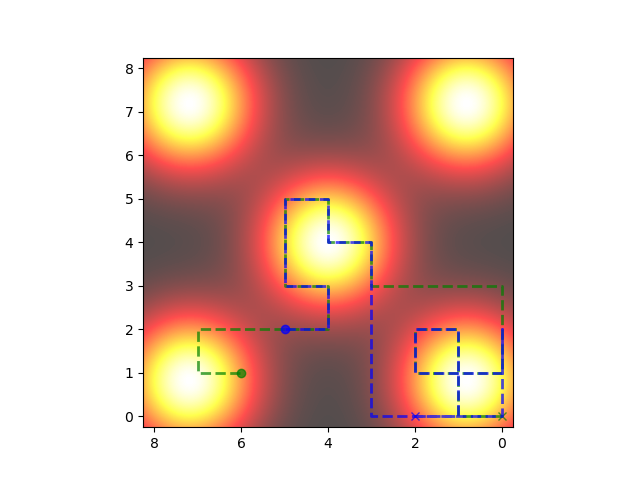

In [59]:
anim_rh_sa_vulcan = plot_animation(rh_sa_vulcan, reward_map, zz, zz_obstacle)

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


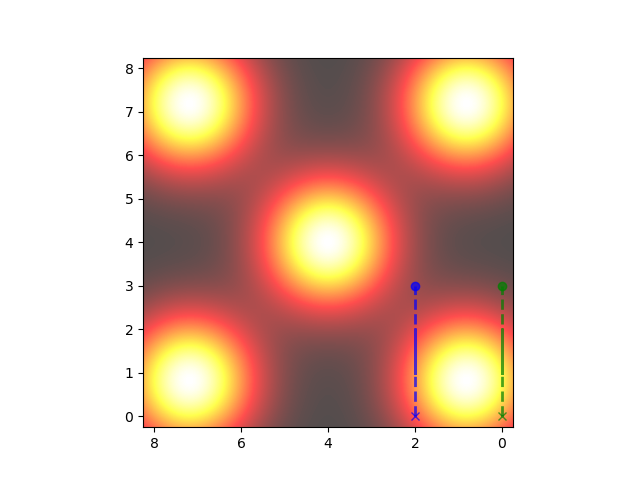

In [60]:
anim_rh_sa_ca_vulcan = plot_animation(rh_sa_ca_vulcan, reward_map, zz, zz_obstacle)

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


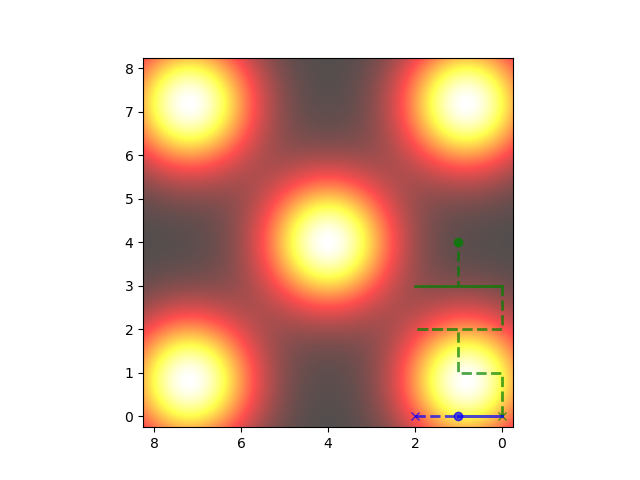

In [61]:
anim_rh_ma_mcts_vulcan = plot_animation(rh_ma_mcts_vulcan, reward_map, zz, zz_obstacle)

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


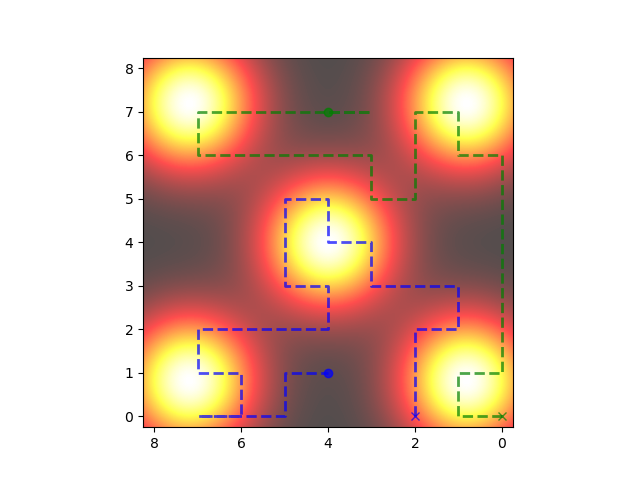

In [62]:
anim_rh_ma_vulcan = plot_animation(rh_ma_vulcan, reward_map, zz, zz_obstacle)

#### Empty Space - 3 Robots

In [63]:
agent_a = [np.array([0, 0]), np.array([0, 1]), np.array([1, 1]), np.array([1, 2]), np.array([2, 2]), np.array([2, 1]), np.array([1, 1]), np.array([1, 0]), np.array([1, 1]), np.array([2, 1]), np.array([3, 1]), np.array([3, 2]), np.array([3, 3]), np.array([3, 4]), np.array([4, 4]), np.array([4, 5]), np.array([5, 5]), np.array([5, 4]), np.array([5, 3]), np.array([4, 3]), np.array([4, 2]), np.array([5, 2]), np.array([6, 2]), np.array([7, 2]), np.array([7, 1]), np.array([7, 0])]
agent_b = [np.array([0, 2]), np.array([1, 2]), np.array([1, 1]), np.array([2, 1]), np.array([1, 1]), np.array([0, 1]), np.array([0, 0]), np.array([1, 0]), np.array([1, 1]), np.array([1, 2]), np.array([2, 2]), np.array([3, 2]), np.array([3, 3]), np.array([3, 4]), np.array([4, 4]), np.array([4, 5]), np.array([5, 5]), np.array([5, 4]), np.array([5, 3]), np.array([4, 3]), np.array([4, 2]), np.array([5, 2]), np.array([6, 2]), np.array([7, 2]), np.array([7, 1]), np.array([6, 1])]
agent_c = [np.array([2, 0]), np.array([2, 1]), np.array([1, 1]), np.array([1, 2]), np.array([0, 2]), np.array([0, 1]), np.array([0, 0]), np.array([1, 0]), np.array([2, 0]), np.array([2, 1]), np.array([2, 2]), np.array([3, 2]), np.array([3, 3]), np.array([3, 4]), np.array([4, 4]), np.array([4, 5]), np.array([5, 5]), np.array([5, 4]), np.array([5, 3]), np.array([4, 3]), np.array([4, 2]), np.array([5, 2]), np.array([6, 2]), np.array([7, 2]), np.array([7, 1]), np.array([7, 2])]
rh_sa_vulcan = [agent_a, agent_b, agent_c]

agent_a = [np.array([0, 0]), np.array([0, 1]), np.array([0, 2]), np.array([0, 1]), np.array([0, 2]), np.array([0, 1]), np.array([0, 2]), np.array([0, 1]), np.array([0, 2]), np.array([0, 1]), np.array([0, 2]), np.array([0, 1]), np.array([0, 2]), np.array([0, 1]), np.array([0, 2]), np.array([0, 1]), np.array([0, 2]), np.array([0, 1]), np.array([0, 2]), np.array([0, 1]), np.array([0, 2]), np.array([0, 1]), np.array([0, 2]), np.array([0, 1]), np.array([0, 2]), np.array([0, 3])]
agent_b = [np.array([0, 2]), np.array([1, 2]), np.array([1, 3]), np.array([2, 3]), np.array([2, 4]), np.array([2, 5]), np.array([3, 5]), np.array([4, 5]), np.array([5, 5]), np.array([4, 5]), np.array([3, 5]), np.array([4, 5]), np.array([3, 5]), np.array([4, 5]), np.array([3, 5]), np.array([4, 5]), np.array([3, 5]), np.array([4, 5]), np.array([3, 5]), np.array([4, 5]), np.array([3, 5]), np.array([4, 5]), np.array([3, 5]), np.array([4, 5]), np.array([3, 5]), np.array([3, 6])]
agent_c = [np.array([2, 0]), np.array([2, 1]), np.array([2, 0]), np.array([2, 1]), np.array([2, 2]), np.array([2, 1]), np.array([2, 2]), np.array([2, 1]), np.array([2, 2]), np.array([2, 1]), np.array([2, 2]), np.array([2, 1]), np.array([2, 2]), np.array([2, 1]), np.array([2, 2]), np.array([2, 1]), np.array([2, 2]), np.array([2, 1]), np.array([2, 2]), np.array([2, 1]), np.array([2, 2]), np.array([2, 1]), np.array([2, 2]), np.array([2, 1]), np.array([2, 2]), np.array([3, 2])]
rh_sa_ca_vulcan = [agent_a, agent_b, agent_c]

agent_a = [np.array([0, 0]), np.array([1, 0]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0]), np.array([1, 0]), np.array([0, 0]), np.array([1, 0]), np.array([0, 0]), np.array([1, 0]), np.array([0, 0]), np.array([1, 0]), np.array([0, 0]), np.array([1, 0]), np.array([0, 0]), np.array([1, 0]), np.array([0, 0]), np.array([1, 0]), np.array([0, 0]), np.array([1, 0]), np.array([0, 0]), np.array([1, 0]), np.array([0, 0]), np.array([1, 0]), np.array([0, 0]), np.array([1, 0])]
agent_b = [np.array([0, 2]), np.array([1, 2]), np.array([1, 1]), np.array([1, 0]), np.array([2, 0]), np.array([3, 0]), np.array([2, 0]), np.array([3, 0]), np.array([2, 0]), np.array([3, 0]), np.array([2, 0]), np.array([3, 0]), np.array([2, 0]), np.array([3, 0]), np.array([2, 0]), np.array([3, 0]), np.array([2, 0]), np.array([3, 0]), np.array([2, 0]), np.array([3, 0]), np.array([2, 0]), np.array([3, 0]), np.array([2, 0]), np.array([3, 0]), np.array([2, 0]), np.array([3, 0])]
agent_c = [np.array([2, 0]), np.array([2, 1]), np.array([2, 0]), np.array([3, 0]), np.array([4, 0]), np.array([4, 1]), np.array([4, 2]), np.array([3, 2]), np.array([2, 2]), np.array([1, 2]), np.array([0, 2]), np.array([0, 3]), np.array([1, 3]), np.array([2, 3]), np.array([3, 3]), np.array([2, 3]), np.array([1, 3]), np.array([0, 3]), np.array([0, 2]), np.array([0, 1]), np.array([1, 1]), np.array([0, 1]), np.array([1, 1]), np.array([0, 1]), np.array([1, 1]), np.array([0, 1])]
rh_ma_mcts_vulcan = [agent_a, agent_b, agent_c]

agent_a = [np.array([0, 0]), np.array([0, 1]), np.array([1, 1]), np.array([1, 0]), np.array([2, 0]), np.array([3, 0]), np.array([4, 0]), np.array([5, 0]), np.array([6, 0]), np.array([7, 0]), np.array([7, 1]), np.array([7, 2]), np.array([7, 3]), np.array([6, 3]), np.array([6, 4]), np.array([6, 5]), np.array([6, 6]), np.array([6, 7]), np.array([5, 7]), np.array([4, 7]), np.array([3, 7]), np.array([3, 6]), np.array([3, 5]), np.array([3, 4]), np.array([2, 4]), np.array([2, 3])]
agent_b = [np.array([0, 2]), np.array([1, 2]), np.array([2, 2]), np.array([2, 3]), np.array([2, 4]), np.array([3, 4]), np.array([3, 5]), np.array([4, 5]), np.array([5, 5]), np.array([5, 6]), np.array([6, 6]), np.array([6, 7]), np.array([7, 7]), np.array([7, 6]), np.array([7, 5]), np.array([7, 4]), np.array([7, 5]), np.array([6, 5]), np.array([6, 4]), np.array([5, 4]), np.array([5, 5]), np.array([5, 6]), np.array([4, 6]), np.array([3, 6]), np.array([3, 7]), np.array([2, 7])]
agent_c = [np.array([2, 0]), np.array([2, 1]), np.array([3, 1]), np.array([3, 2]), np.array([3, 3]), np.array([4, 3]), np.array([4, 4]), np.array([5, 4]), np.array([5, 3]), np.array([5, 2]), np.array([6, 2]), np.array([6, 1]), np.array([5, 1]), np.array([4, 1]), np.array([4, 2]), np.array([3, 2]), np.array([3, 3]), np.array([2, 3]), np.array([1, 3]), np.array([1, 4]), np.array([1, 5]), np.array([1, 6]), np.array([1, 7]), np.array([0, 7]), np.array([0, 6]), np.array([0, 5])]
rh_ma_vulcan = [agent_a, agent_b, agent_c]

In [64]:
%%capture
grid, reward_map, zz, zz_obstacle = setup_problem("empty_3")

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


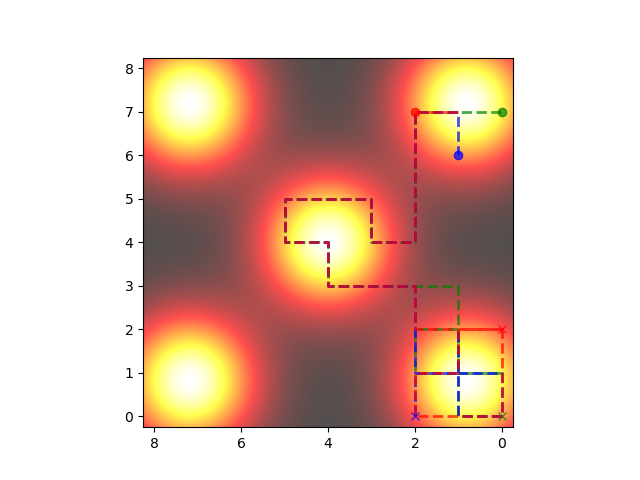

In [65]:
anim_rh_sa_vulcan = plot_animation(rh_sa_vulcan, reward_map, zz, zz_obstacle)

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


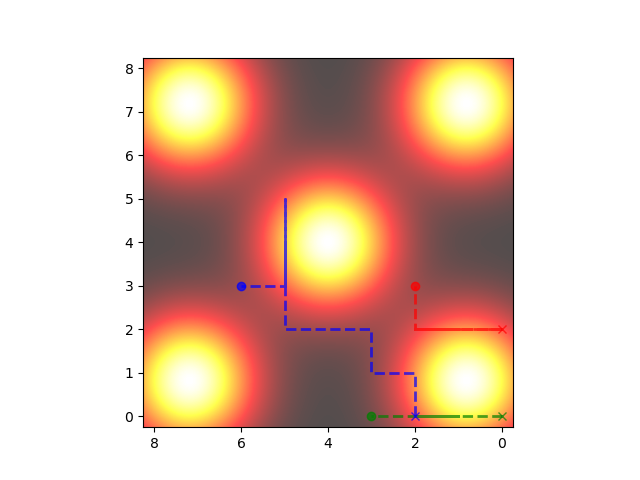

In [66]:
anim_rh_sa_ca_vulcan = plot_animation(rh_sa_ca_vulcan, reward_map, zz, zz_obstacle)

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


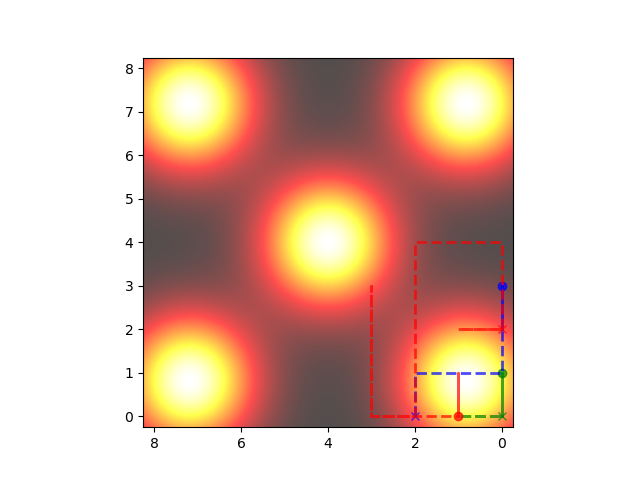

In [67]:
anim_rh_ma_mcts_vulcan = plot_animation(rh_ma_mcts_vulcan, reward_map, zz, zz_obstacle)

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


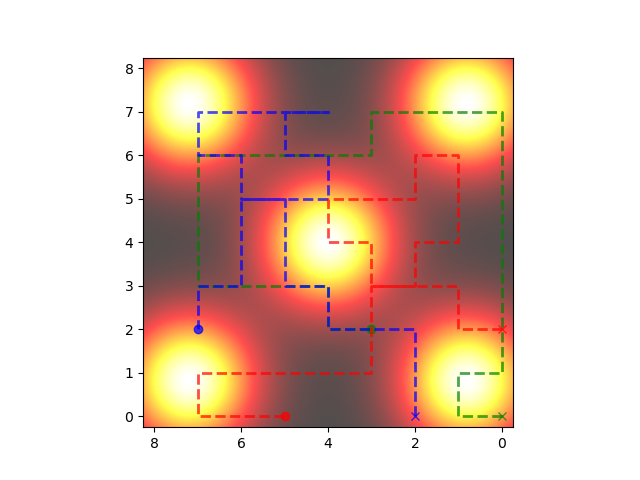

In [68]:
anim_rh_ma_vulcan = plot_animation(rh_ma_vulcan, reward_map, zz, zz_obstacle)

#### Maze - 2 Robots

In [69]:
agent_a = [np.array([0, 0]), np.array([1, 0]), np.array([1, 1]), np.array([2, 1]), np.array([1, 1]), np.array([0, 1]), np.array([0, 0]), np.array([1, 0]), np.array([2, 0]), np.array([3, 0]), np.array([3, 1]), np.array([3, 2]), np.array([3, 3]), np.array([3, 4]), np.array([4, 4]), np.array([4, 5]), np.array([4, 4]), np.array([4, 3]), np.array([4, 2]), np.array([4, 1]), np.array([5, 1]), np.array([6, 1]), np.array([7, 1]), np.array([7, 2]), np.array([7, 1]), np.array([7, 0])]
agent_b = [np.array([0, 3]), np.array([1, 3]), np.array([1, 4]), np.array([1, 5]), np.array([1, 6]), np.array([1, 7]), np.array([0, 7]), np.array([1, 7]), np.array([2, 7]), np.array([2, 6]), np.array([3, 6]), np.array([3, 5]), np.array([3, 4]), np.array([4, 4]), np.array([4, 3]), np.array([4, 4]), np.array([4, 5]), np.array([4, 6]), np.array([5, 6]), np.array([6, 6]), np.array([7, 6]), np.array([7, 7]), np.array([6, 7]), np.array([5, 7]), np.array([4, 7]), np.array([3, 7])]
rh_sa_vulcan = [agent_a, agent_b]

agent_a = [np.array([0, 0]), np.array([1, 0]), np.array([1, 1]), np.array([2, 1]), np.array([1, 1]), np.array([0, 1]), np.array([0, 0]), np.array([1, 0]), np.array([2, 0]), np.array([3, 0]), np.array([3, 1]), np.array([3, 2]), np.array([3, 3]), np.array([4, 3]), np.array([3, 3]), np.array([3, 4]), np.array([3, 5]), np.array([4, 5]), np.array([4, 4]), np.array([4, 5]), np.array([4, 6]), np.array([4, 7]), np.array([5, 7]), np.array([6, 7]), np.array([7, 7]), np.array([6, 7])]
agent_b = [np.array([0, 3]), np.array([1, 3]), np.array([1, 4]), np.array([1, 5]), np.array([1, 6]), np.array([1, 7]), np.array([0, 7]), np.array([1, 7]), np.array([2, 7]), np.array([3, 7]), np.array([3, 6]), np.array([3, 5]), np.array([3, 4]), np.array([4, 4]), np.array([4, 5]), np.array([4, 4]), np.array([4, 3]), np.array([3, 3]), np.array([3, 2]), np.array([3, 1]), np.array([2, 1]), np.array([1, 1]), np.array([1, 0]), np.array([0, 0]), np.array([0, 1]), np.array([0, 0])]
rh_sa_ca_vulcan = [agent_a, agent_b]

agent_a = [np.array([0, 0]), np.array([1, 0]), np.array([1, 1]), np.array([2, 1]), np.array([1, 1]), np.array([0, 1]), np.array([0, 0]), np.array([1, 0]), np.array([2, 0]), np.array([3, 0]), np.array([3, 1]), np.array([3, 2]), np.array([3, 3]), np.array([3, 4]), np.array([3, 5]), np.array([3, 6]), np.array([3, 7]), np.array([2, 7]), np.array([1, 7]), np.array([0, 7]), np.array([0, 6]), np.array([0, 7]), np.array([0, 6]), np.array([0, 7]), np.array([0, 6]), np.array([0, 7])]
agent_b = [np.array([0, 3]), np.array([0, 4]), np.array([0, 5]), np.array([0, 6]), np.array([0, 7]), np.array([1, 7]), np.array([1, 6]), np.array([2, 6]), np.array([2, 7]), np.array([3, 7]), np.array([3, 6]), np.array([3, 5]), np.array([3, 6]), np.array([3, 7]), np.array([2, 7]), np.array([1, 7]), np.array([0, 7]), np.array([0, 6]), np.array([0, 5]), np.array([0, 4]), np.array([0, 5]), np.array([0, 6]), np.array([0, 5]), np.array([0, 6]), np.array([0, 5]), np.array([1, 5])]
rh_ma_mcts_vulcan = [agent_a, agent_b]

agent_a = [np.array([0, 0]), np.array([0, 1]), np.array([1, 1]), np.array([1, 0]), np.array([2, 0]), np.array([2, 1]), np.array([3, 1]), np.array([3, 2]), np.array([3, 3]), np.array([3, 4]), np.array([4, 4]), np.array([4, 3]), np.array([4, 2]), np.array([4, 1]), np.array([5, 1]), np.array([6, 1]), np.array([7, 1]), np.array([7, 2]), np.array([7, 1]), np.array([7, 0]), np.array([6, 0]), np.array([6, 1]), np.array([6, 2]), np.array([6, 3]), np.array([6, 4]), np.array([7, 4])]
agent_b = [np.array([0, 3]), np.array([1, 3]), np.array([1, 4]), np.array([1, 5]), np.array([1, 6]), np.array([1, 7]), np.array([0, 7]), np.array([1, 7]), np.array([2, 7]), np.array([2, 6]), np.array([3, 6]), np.array([3, 5]), np.array([4, 5]), np.array([4, 6]), np.array([5, 6]), np.array([6, 6]), np.array([7, 6]), np.array([7, 7]), np.array([6, 7]), np.array([5, 7]), np.array([4, 7]), np.array([3, 7]), np.array([3, 6]), np.array([3, 7]), np.array([3, 6]), np.array([3, 7])]
rh_ma_vulcan = [agent_a, agent_b]

In [70]:
%%capture
grid, reward_map, zz, zz_obstacle = setup_problem("maze_2")

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


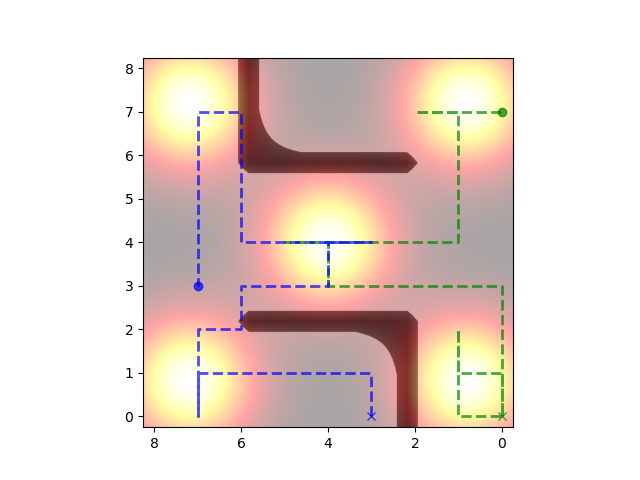

In [71]:
anim_rh_sa_vulcan = plot_animation(rh_sa_vulcan, reward_map, zz, zz_obstacle)

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


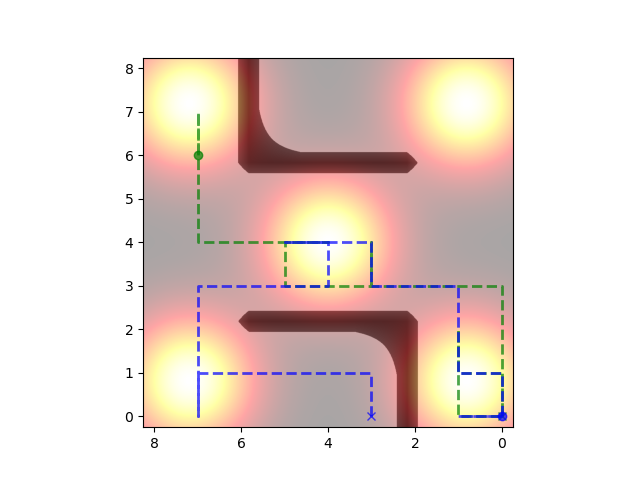

In [72]:
anim_rh_sa_ca_vulcan = plot_animation(rh_sa_ca_vulcan, reward_map, zz, zz_obstacle)

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


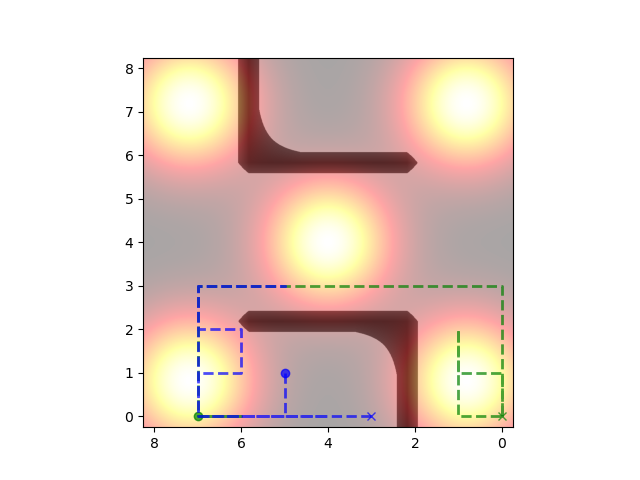

In [73]:
anim_rh_ma_mcts_vulcan = plot_animation(rh_ma_mcts_vulcan, reward_map, zz, zz_obstacle)

/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  starts[i].set_data(path[0][1], path[0][0])
/var/folders/by/w32zlc7d7jl9zt_zh25lsjq80000gn/T/ipykernel_44892/1154865279.py:47: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ends[i].set_data(path[frame][1], path[frame][0])


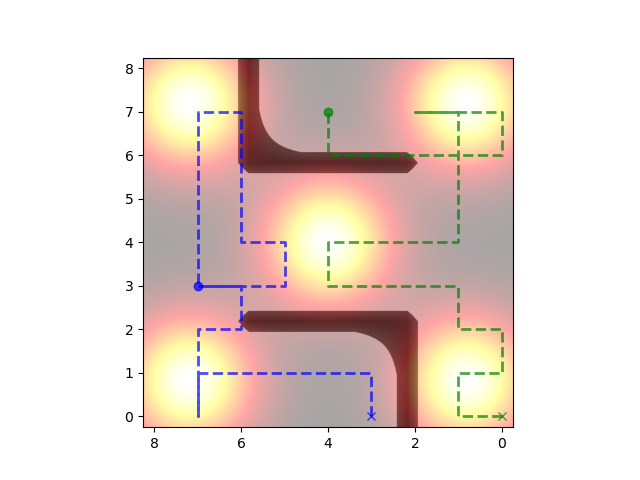

In [74]:
anim_rh_ma_vulcan = plot_animation(rh_ma_vulcan, reward_map, zz, zz_obstacle)